##1. import & Data load

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
!pip install xgboost
!pip install catboost
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [17]:
train = pd.read_csv('/home/jingi/Dacon/HD/dataset/train.csv')
test = pd.read_csv('/home/jingi/Dacon/HD/dataset/test.csv')

train, test SAMPLE_ID, ID 삭제

##2. EDA & Preprocessing

In [18]:
# 데이터 탐색
display(train.head())
display(train.info())
display(train.describe())
# 결측치 확인
display(train.isnull().sum())

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           391939 non-null  object 
 1   ARI_CO              391939 non-null  object 
 2   ARI_PO              391939 non-null  object 
 3   SHIP_TYPE_CATEGORY  391939 non-null  object 
 4   DIST                391939 non-null  float64
 5   ATA                 391939 non-null  object 
 6   ID                  391939 non-null  object 
 7   BREADTH             391938 non-null  float64
 8   BUILT               391939 non-null  int64  
 9   DEADWEIGHT          391939 non-null  int64  
 10  DEPTH               391938 non-null  float64
 11  DRAUGHT             391938 non-null  float64
 12  GT                  391939 non-null  int64  
 13  LENGTH              391938 non-null  float64
 14  SHIPMANAGER         391939 non-null  object 
 15  FLAG                391939 non-nul

None

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


SAMPLE_ID                  0
ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

1. 범주형 변수: ARI_CO, ARI_PO, SHIP_TYPE_CATEGORY ,SHIPMANAGER ,FLAG
2. 수치형 변수: 나머지
3. 풍향 u,v벡터, 기온, 보퍼트 풍력 계급 변수에 결측치 존재

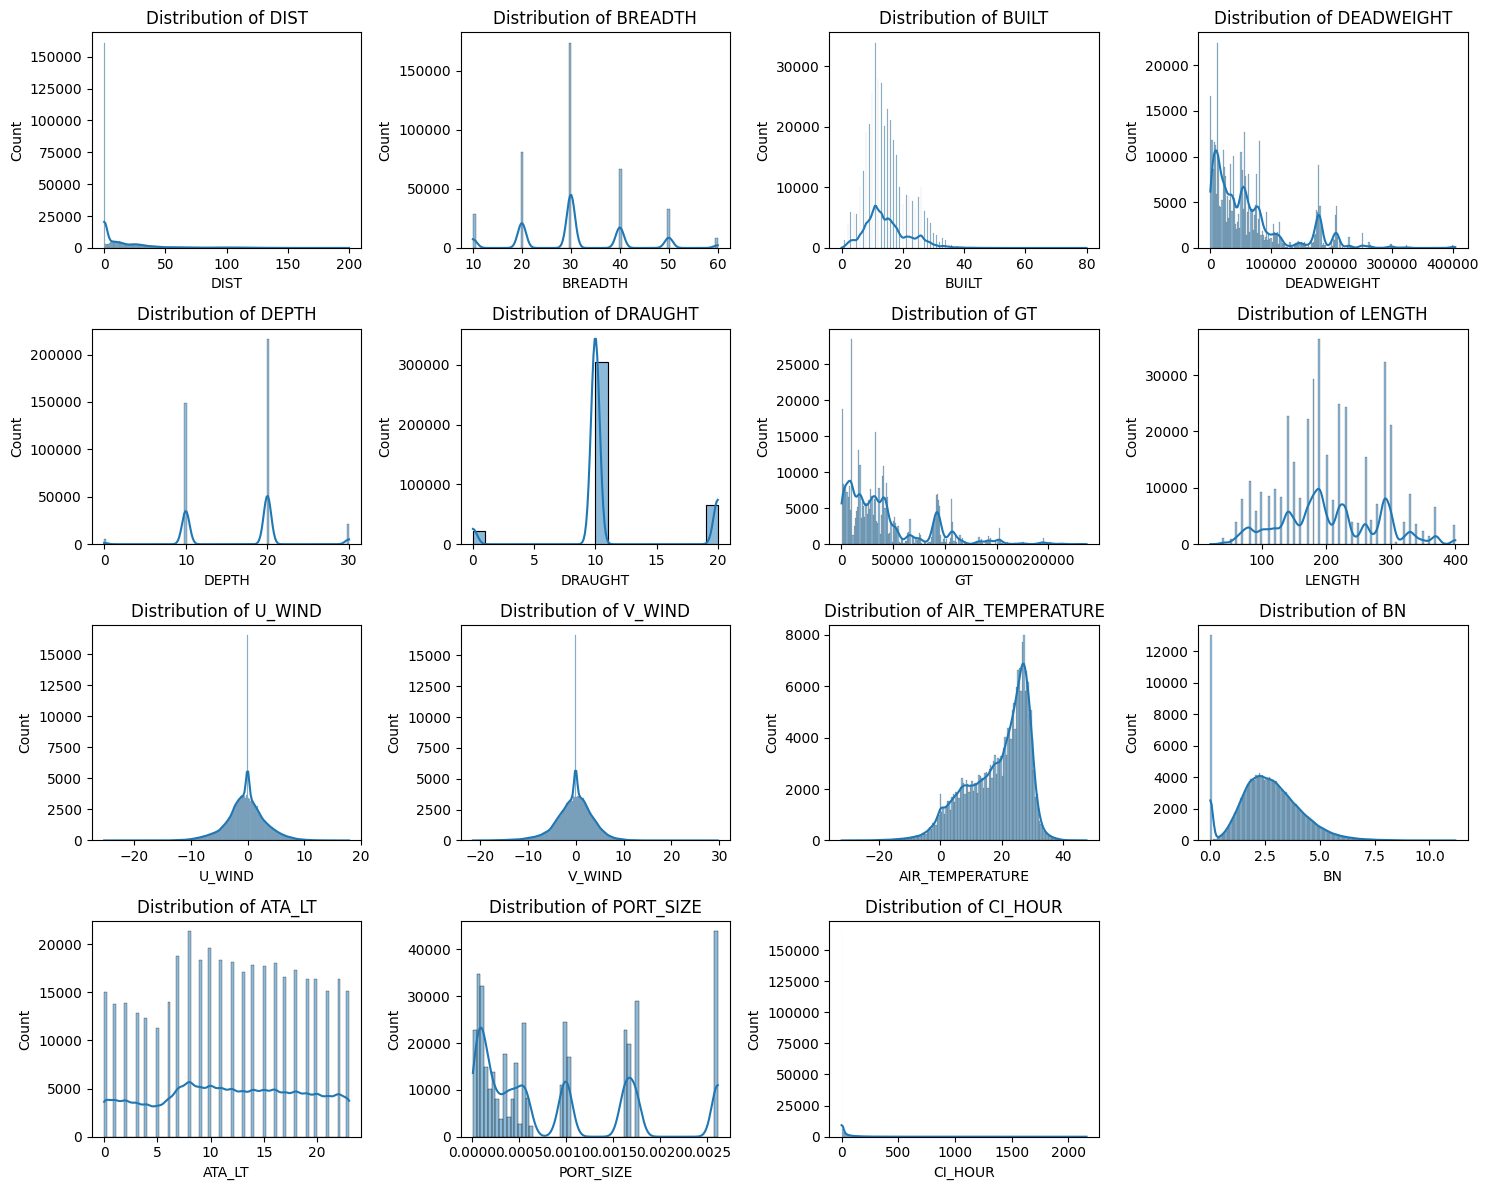

In [19]:
num_cols=['DIST', 'BREADTH', 'BUILT','DEADWEIGHT', 'DEPTH','DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN','ATA_LT', 'PORT_SIZE','CI_HOUR']

# 그래프의 크기 및 행, 열 설정
num_cols_count = len(num_cols)
num_cols_per_row = 4  # 각 행당 그래프 수를 조절
num_rows = int(math.ceil(num_cols_count / num_cols_per_row))

plt.figure(figsize=(15, 3 * num_rows))

for i, feature in enumerate(num_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)
    sns.histplot(train[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# 그래프 출력
plt.tight_layout()
plt.show()

In [20]:
# # 시각화를 통한 데이터 탐색
# plt.figure(figsize=(16, 8))
# sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# plt.show()

1. DIST 변수가 제일 상관관계 높았지만 유의미한 수준이 아님
2. 선박의 크기및 용적량 변수들 끼리의 상관계수 높게 측정

* breadth, deadweight, depth, draught, gt, length - [폭, 재화중량톤수, 깊이, 흘수높이, 용적톤수, 길이]

In [21]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
print(CI_HOUR_NOT_0_idx)
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
train

[2521, 6439, 24059, 26501, 36741, 39476, 59076, 66864, 69524, 73609, 77864, 111963, 114363, 130517, 146884, 196830, 212002, 215246, 237240, 237396, 270856, 297812, 306130, 314316, 350939, 357643, 378544, 389245]


,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,TRAIN_391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,...,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,TRAIN_391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,TRAIN_391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TRAIN_391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,...,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [22]:
# BUILT, ATA_LT 컬럼 제거
train.drop(columns=['BUILT', 'ATA_LT'], inplace=True)
test.drop(columns=['BUILT', 'ATA_LT'], inplace=True)

train.head(5)

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,DEADWEIGHT,DEPTH,...,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24300,10.0,...,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,35900,10.0,...,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,146000,30.0,...,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,6910,10.0,...,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,116000,20.0,...,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,0.002615,253.554444


1. 유의미한 선형적 관계를 볼 수는 없다.
2. BUILT, ATA_LT 컬럼 제거(종속변수와의 선형관계 0)

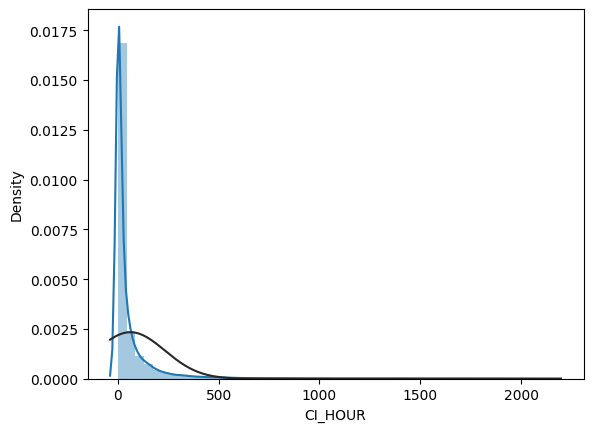

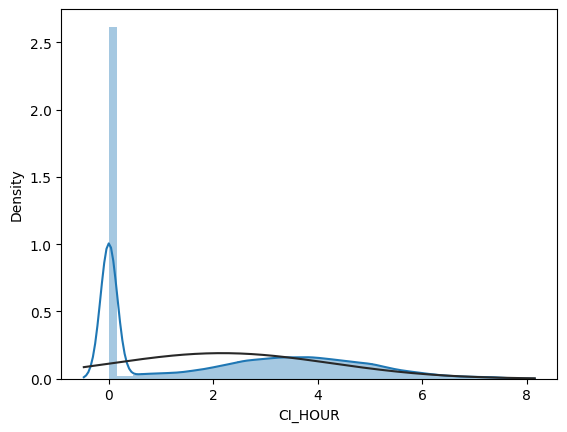

<Figure size 640x480 with 0 Axes>

In [23]:
# 종속변수 Log 변환
sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

train.CI_HOUR = np.log1p(train.CI_HOUR)

sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

In [25]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

KeyError: 'ATA'

In [28]:
train.columns

Index(['SAMPLE_ID', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG',
       'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday', 'ARI_COPO'],
      dtype='object')

In [30]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import bisect

categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY',  'SHIPMANAGER', 'FLAG']
encoders = {}


for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    encoders[feature] = le

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    test[feature] = le.fit_transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 4/4 [00:00<00:00, 13.52it/s]

In [ ]:
#수치형 데이터를 표준화
num_features=['DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND','AIR_TEMPERATURE', 'BN', 'PORT_SIZE']

scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [ ]:
train.head(5)

,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,ARI_COPO
0,2,0.373515,-0.050197,-0.618393,-1.071166,-0.236581,-0.627129,-0.331094,686,89,...,4.192532e-16,2.075833,1.492904,2018,12,17,21,29,0,90
1,0,-0.624901,-0.050197,-0.435760,-1.071166,-0.236581,-0.454120,-0.331094,4720,74,...,4.192532e-16,-0.787562,0.000000,2014,9,23,6,59,1,52
2,2,-0.624901,1.775113,1.297676,2.236853,1.937669,2.509917,2.173068,1370,73,...,4.192532e-16,0.880664,0.000000,2015,2,3,22,0,1,23
3,2,-0.624901,-0.962852,-0.892185,-1.071166,-0.236581,-0.914627,-1.121882,3809,5,...,-7.330055e-02,-0.621043,0.000000,2020,1,17,4,2,4,66
4,2,0.249255,1.775113,0.825350,0.582844,-0.236581,1.405718,1.250482,1687,67,...,-1.992371e-01,2.075833,5.539515,2020,1,26,7,51,6,90


1. 범주형 및 datetime 컬럼 처리
2. 수치데이터 표준화

### LGBM feature selection

Model Tune for lgbm.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 22
[LightGBM] [Info] Start training from score 2.163121


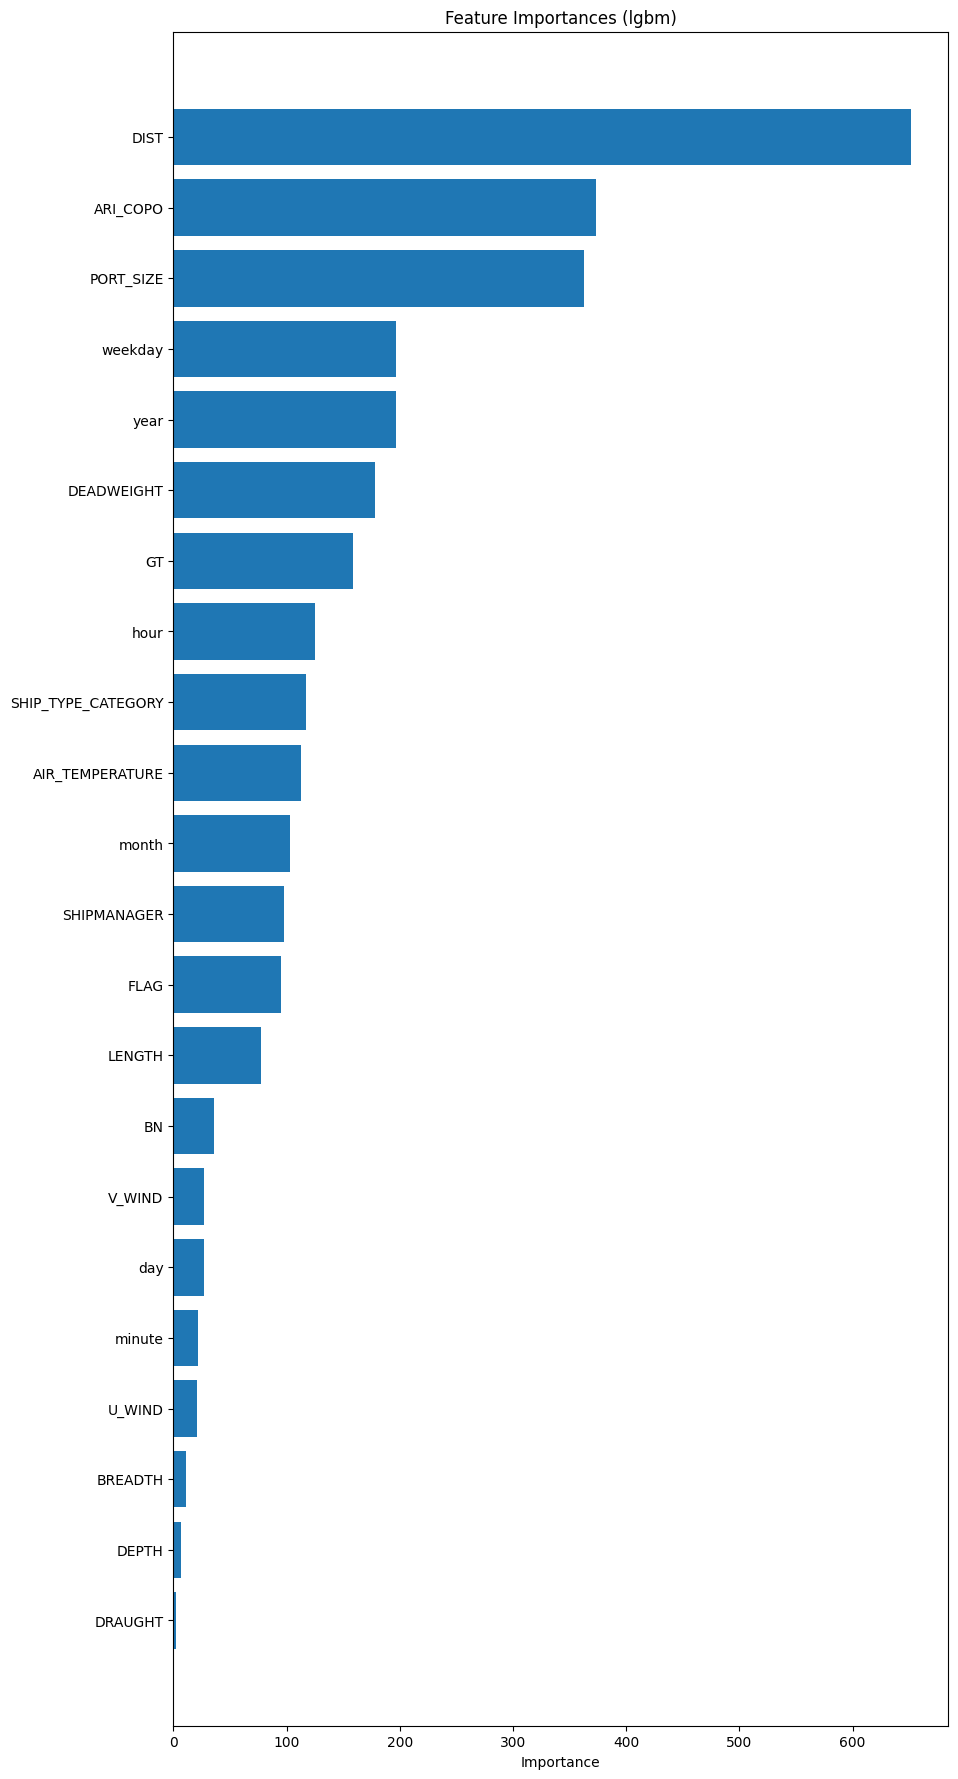

In [ ]:
def train_and_evaluate(model, model_name, train_x, train_y):
    print(f'Model Tune for {model_name}.')
    model.fit(train_x, train_y)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(train_x.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(train_x.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(train_x.shape[1]), train_x.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(LGBMRegressor(), 'lgbm', train_x, train_y)

In [ ]:
lgbm_feature_importances

array([117, 652,  11, 178,   7,   2, 159,  77,  98,  95,  21,  27, 113,
        36, 363, 197, 103,  27, 125,  22, 197, 373], dtype=int32)

In [ ]:
lgbm_feature_importances.columns

#### PCA 추가

In [ ]:
import pandas as pd

# 가상의 특성 중요도 데이터프레임 생성
feature_importance = pd.DataFrame({
    'name_list': ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'ARI_COPO', 'hour_cos',
       'month_cos', 'day_cos', 'weekday_cos', 'minute_cos', 'year_cos'],
    'Importance': [117, 652,  11, 178,   7,   2, 159,  77,  98,  95,  21,  27, 113,
        36, 363, 197, 103,  27, 125,  22, 197, 373]
})

# 원하는 그룹 수 설정
num_groups = 4

# 중요도 값에 따라 특성 정렬
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 그룹별로 특성을 나누기 위한 그룹 크기 계산
group_size = len(feature_importance) // num_groups

# 그룹별로 특성 나누기
feature_groups = []
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = feature_importance.iloc[start_idx:end_idx]['name_list'].tolist()  # 'name_list'로 수정
    feature_groups.append(group)

# 원하는 그룹을 정의
# group_definitions = [['DIST', 'PORT_SIZE', 'ARI_COPO'], ['weekday_cos', 'year_cos']]
# feature_groups = []
# for group_definition in group_definitions:
#     group = feature_importance[feature_importance['name_list'].isin(group_definition)]['name_list'].tolist()
#     feature_groups.append(group)

# 결과 출력
for i, group in enumerate(feature_groups):
    print(f'Group {i + 1}: {group}')


In [ ]:
feature_groups

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# groups = [feature_groups[0], feature_groups[1], feature_groups[2], feature_groups[3]]
# featuregroups = [['DIST', 'PORT_SIZE'],['PORT_SIZE', 'ARI_COPO'],['weekday_cos', 'year_cos']]
groups = [feature_groups[0]]

pca_data1 = []
pca_test1 = []
pca_columns = ['PCA_Group0']
for i,group in enumerate(groups):
    # 데이터 선택
    selected_data_X = train_x[group]

    # PCA
    pca = PCA(n_components=1)
    selected_data_X_pca = pca.fit_transform(selected_data_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_data1.append(pd.DataFrame(selected_data_X_pca, columns=[pca_columns[i]]))

    selected_test_X = test[group]

    # PCA
    pca = PCA(n_components=1)
    selected_test_X_pca = pca.fit_transform(selected_test_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_test1.append(pd.DataFrame(selected_test_X_pca, columns=[pca_columns[i]]))

# 각 그룹의 PCA 결과 데이터를 수평으로 연결하여 하나의 변수로 합침
merged_data_df = pd.concat(pca_data1, axis=1)
merged_test_df = pd.concat(pca_test1, axis=1)

# Result 확인
merged_data_df

In [ ]:
threshold = 95 # Your Threshold -> 중요도 상위 9개
low_importance_features = train_x.columns[lgbm_feature_importances < threshold]

train_x = train_x.drop(columns=low_importance_features)
test = test.drop(columns=low_importance_features)

In [ ]:
low_importance_features

Index(['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'U_WIND', 'V_WIND', 'BN',
       'day', 'minute'],
      dtype='object')

In [ ]:
train_x

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,SHIPMANAGER,FLAG,AIR_TEMPERATURE,PORT_SIZE,year,month,hour,weekday,ARI_COPO
0,2,0.373515,-0.618393,-0.627129,686,89,4.794577e-16,2.075833,2018,12,21,0,90
1,0,-0.624901,-0.435760,-0.454120,4720,74,4.794577e-16,-0.787562,2014,9,6,1,52
2,2,-0.624901,1.297676,2.509917,1370,73,4.794577e-16,0.880664,2015,2,22,1,23
3,2,-0.624901,-0.892185,-0.914627,3809,5,-1.641458e+00,-0.621043,2020,1,4,4,66
4,2,0.249255,0.825350,1.405718,1687,67,9.091985e-01,2.075833,2020,1,7,6,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,-0.624901,-0.893602,-0.929384,2562,20,4.794577e-16,-0.387543,2017,6,5,1,61
391935,0,-0.434645,-0.951225,-1.011309,2400,124,1.138623e+00,2.075833,2019,10,0,2,90
391936,0,1.659619,-0.051602,-0.166621,6106,102,3.018994e-01,-0.861057,2021,3,22,1,97
391937,2,-0.319431,-0.626265,-0.622040,1771,22,4.794577e-16,0.135189,2015,1,7,3,93


### 모델 앙상블

In [ ]:
X_train_f = pd.concat([train_x, merged_data_df], axis=1)
X_test_f = pd.concat([test, merged_test_df], axis=1)

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [ ]:
# 각 회귀 모델 생성
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)
rf_model = RandomForestRegressor(random_state=42)
svr_model = SVR()

# VotingRegressor 생성
voting_regressor = VotingRegressor(estimators=[
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('svr', svr_model)
], weights=[1, 2, 3, 2, 1, 1])

# VotingRegressor 학습
voting_regressor.fit(X_train_f, train_y)

In [ ]:
# VotingRegressor로 예측
voting_pred = voting_regressor.predict(X_test_f)

In [ ]:
# MAE 계산
voting_mae = mean_absolute_error(train_y, voting_pred)
print(f"VotingRegressor MAE: {voting_mae}")

##4. 결과 제출

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/home/jingi/Dacon/HD/dataset/sample_submission.csv')
submission.shape

(220491, 2)

In [ ]:
# submission10 -> 이상치 제거(종속변수 제외) + 표준화 + 종속변수 로그화 + XGBOOST
submission["CI_HOUR"]=voting_pred
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,13.522255
1,TEST_000001,21.273937
2,TEST_000002,35.667992
3,TEST_000003,73.432411
4,TEST_000004,0.018958


In [ ]:
# CSV 파일로 저장
submission.to_csv("/home/jingi/Dacon/HD/dataset/sample_submission1.csv", index=False)

In [ ]:
from google.colab import files
files.download("/home/jingi/Dacon/HD/dataset/sample_submission.csv")